# Loot box simulation!
Personal project inspired by gacha games and games that involve some kind of "loot box" system.  
Let's start by defining a probability table for different rarities.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

In [ ]:
rarity_table = {
    "Common":0.6,
    "Uncommon":0.2,
    "Rare":0.1,
    "Epic":0.07,
    "Legendary":0.03
}

Loot box function

In [ ]:
def loot_box(rarity_table = rarity_table):
  roll = random.random()
  cumulative = 0.0
  for rarity, probability in rarity_table.items():
    cumulative += probability
    if roll <= cumulative:
      return rarity

In [ ]:
loot = [loot_box() for x in range(100000)]
loot_df = pd.DataFrame(Counter(loot), index=["Count"]).T
loot_df.sort_values(by="Count", ascending=False, inplace=True)

loot_df

,Count
Common,59790
Uncommon,20195
Rare,9923
Epic,7007
Legendary,3085


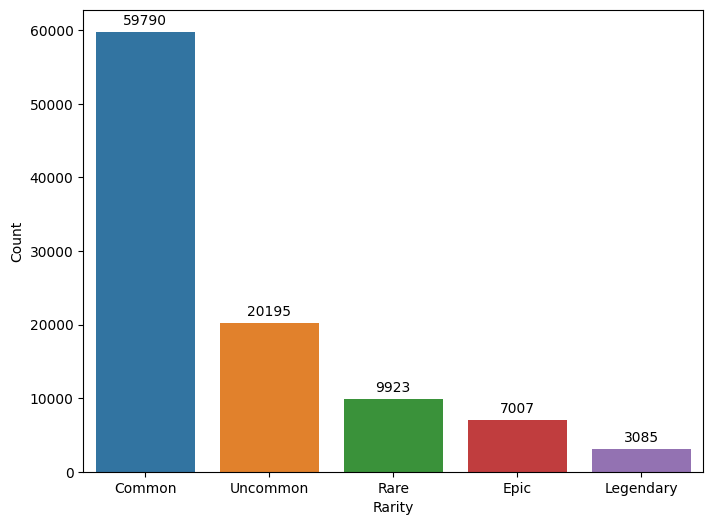

In [ ]:
plt.figure(figsize=(8, 6))
plot = sns.barplot(x=loot_df.index,
                 y=loot_df["Count"],
                 hue=loot_df.index,
                 legend=False)

for i, count in enumerate(loot_df["Count"]):
  plot.text(i,
            count + max(loot_df["Count"]) * 0.01,
            str(count),
            ha='center',
            va='bottom')

plt.ylabel("Count")
plt.xlabel("Rarity")
plt.show()

Some gacha games incorporate a "pity system," which increases the probability of powerful loot after a certain number of rolls. Let's simulate that as well!

In [ ]:
def loot_with_pity(rolls, rolls_before_pity=19, pity_weights=[0.35 ,0.65]):
  counter = 0
  pity_triggers = 0
  loot = []

  for i in range(rolls):
    if counter == rolls_before_pity:
      rarity = random.choices(
          ["Epic", "Legendary"],
          weights=pity_weights,
          k=1
          )[0]
      loot.append(rarity)
      pity_triggers += 1
      counter = 0

    else:
      rarity = loot_box()
      loot.append(rarity)
      if rarity == "Legendary":
        counter = 0
      else:
        counter += 1

  return Counter(loot), pity_triggers

In [ ]:
loot_pity_df = pd.DataFrame(loot_with_pity(100000)[0], index=["Count"]).T
loot_pity_df.sort_values(by="Count", ascending=False, inplace=True)

loot_pity_df

,Count
Common,58024
Uncommon,19405
Rare,9626
Epic,6923
Legendary,6022


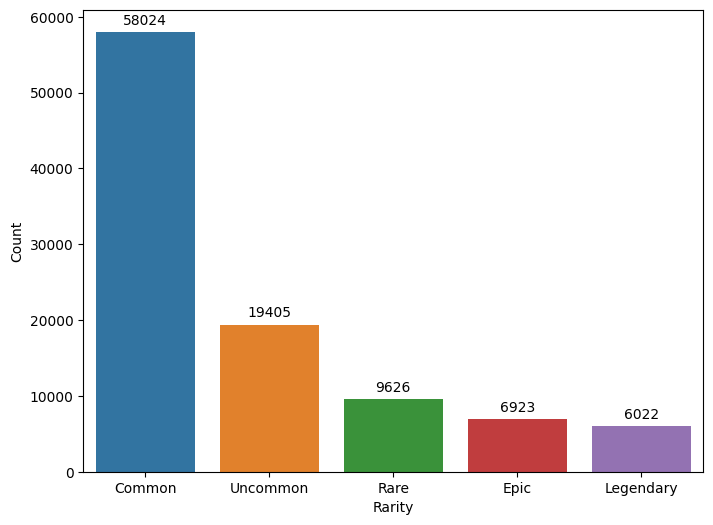

In [ ]:
plt.figure(figsize=(8, 6))
plot = sns.barplot(x=loot_pity_df.index,
                 y=loot_pity_df["Count"],
                 hue=loot_pity_df.index,
                 legend=False)

for i, count in enumerate(loot_pity_df["Count"]):
    plot.text(i,
              count + max(loot_pity_df["Count"]) * 0.01,
              str(count),
              ha='center',
              va='bottom')

plt.ylabel("Count")
plt.xlabel("Rarity")
plt.show()

Let's compare the two plots side-by-side.

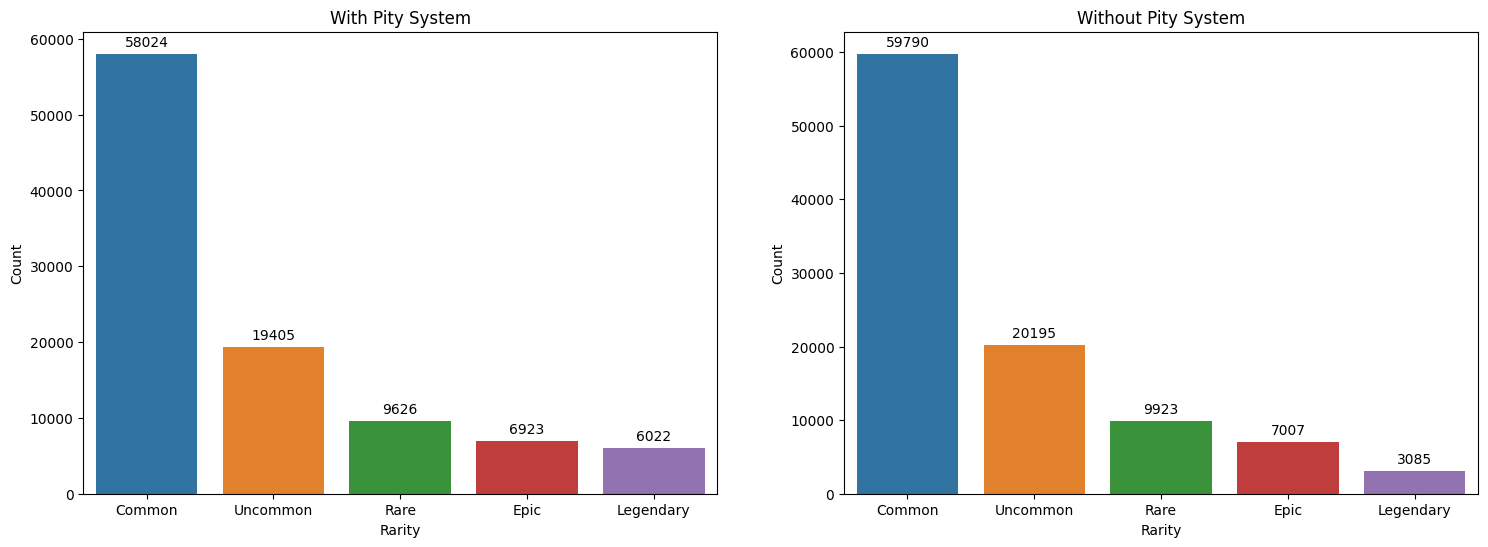

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(18,6))

sns.barplot(x=loot_pity_df.index,
            y=loot_pity_df["Count"],
            hue=loot_pity_df.index,
            legend=False,
            ax=axes[0])

for i, count in enumerate(loot_pity_df["Count"]):
  axes[0].text(i,
               count + max(loot_pity_df["Count"]) * 0.01,
               str(count),
               ha='center',
               va='bottom')

sns.barplot(x=loot_df.index,
            y=loot_df["Count"],
            hue=loot_df.index,
            legend=False,
            ax=axes[1])

axes[1].set_title("Without Pity System")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Rarity")

axes[0].set_title("With Pity System")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Rarity")

for i, count in enumerate(loot_df["Count"]):
  axes[1].text(i, count + max(loot_df["Count"]) * 0.01,
               str(count),
               ha='center',
               va='bottom')

Question: How many rolls should it take for the average player to obtain a legendary?

Suppose our game has a hard pity system.

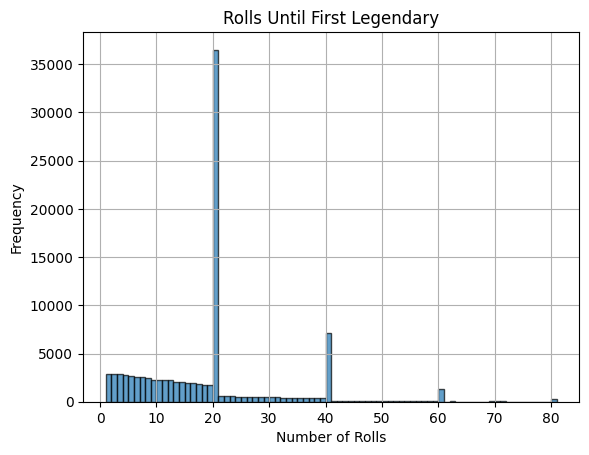

Average rolls to get first Legendary: 18.76


In [ ]:
def rolls_until_first_legendary(
  max_rolls=80,
  rolls_before_pity=19,
  pity_weights=[0.35,0.65]
  ):
  counter = 0

  for i in range(1, max_rolls + 1):
    if counter == rolls_before_pity:
      rarity = random.choices(["Epic", "Legendary"],weights=pity_weights)[0]
      counter = 0

    else:
      rarity = loot_box(rarity_table)
      counter = 0 if rarity == "Legendary" else counter + 1

    if rarity == "Legendary":
      return i

  return 0 # For runs where no legendaries are pulled (doesn't register on plot)

def plot_rolls_to_legendary(n_simulations=100000):
  results = [rolls_until_first_legendary() for _ in range(n_simulations)]

  plt.hist(
      results,
      bins=range(1, max(results)+2),
      edgecolor='black',
      alpha=0.7,
      #density=True # Set density to True to normalize results!
      )

  plt.title('Rolls Until First Legendary')
  plt.xlabel('Number of Rolls')
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

plot_rolls_to_legendary()

results = [rolls_until_first_legendary() for _ in range(100000)]
results = [r for r in results if r>0]
average_rolls = sum(results) / len(results)
print(f"Average rolls to get first Legendary: {average_rolls:.2f}")

Let's also try a pseudorandom probability system, where instead of a guaranteed rare/legendary item after a certain number of rolls, probability of powerful loot incrementally increases with every unsuccessful roll.

In [ ]:
def loot_pseudo_rng(
  rolls=100000,
  start_boost_at=10,
  base_chance=0.01,
  max_chance=1.0,
  increase_per_roll=0.01
):
  counter = 0
  loot = []

  for _ in range(rolls):
    if counter >= start_boost_at:
      extra_chance = (counter - start_boost_at + 1) * increase_per_roll
    else:
      extra_chance = 0

    current_legendary_chance = min(base_chance + extra_chance, max_chance)

    # Dynamic rarity table!
    # We need to scale back non-legendary probabilities to prevent
    # the probability of the entire set exceeding 1
    adjusted_table = rarity_table.copy()
    non_legendary_total = 1 - current_legendary_chance
    scale = non_legendary_total / (1 - rarity_table["Legendary"])

    for rarity in adjusted_table:
      if rarity != "Legendary":
        adjusted_table[rarity] *= scale
    adjusted_table["Legendary"] = current_legendary_chance

    rarity = loot_box(adjusted_table)
    loot.append(rarity)

    if rarity == "Legendary":
      counter = 0
    else:
      counter += 1

  return loot

In [ ]:
loot_pseudo_df = pd.DataFrame(Counter(loot_pseudo_rng()), index=["Count"]).T
loot_pseudo_df
# Much more legendaries with this system

,Count
Uncommon,19397
Common,59147
Rare,9642
Epic,6791
Legendary,5023


Since the pseudorandom system is exceptionally generous, let's compare it with our hard pity system.

In [ ]:
loot_pseudo_df = pd.DataFrame(
    Counter(loot_pseudo_rng()),
    index=["Pseudo-RNG Count"]
    ).T

loot_pity_df = pd.DataFrame(
    loot_with_pity(100000,19,[0.35,0.65])[0],
    index=["Hard Pity Count"]
    ).T

order = ["Common", "Uncommon", "Rare", "Epic", "Legendary"]

loot_pity_df.sort_values(by="Hard Pity Count", ascending=False, inplace=True)

comparison = loot_pity_df.merge(
    loot_pseudo_df,
    left_index=True,
    right_index=True
    )

comparison = comparison.reindex(order)

comparison['Hard Pity Prob'] = (comparison['Hard Pity Count']
                                / comparison['Hard Pity Count'].sum())
comparison['Pseudo-RNG Prob'] = (comparison['Pseudo-RNG Count']
                                / comparison['Pseudo-RNG Count'].sum())
comparison = comparison[[
    'Hard Pity Count',
    'Hard Pity Prob',
    'Pseudo-RNG Count',
    'Pseudo-RNG Prob'
    ]].round(3)

comparison

# By comparing their probabilities, the hard pity system is slightly more
# generous than our pseudorandom system.

,Hard Pity Count,Hard Pity Prob,Pseudo-RNG Count,Pseudo-RNG Prob
Common,57818,0.578,58787,0.588
Uncommon,19214,0.192,19574,0.196
Rare,9623,0.096,9793,0.098
Epic,8007,0.080,6785,0.068
Legendary,5338,0.053,5061,0.051


Question: How many rolls should it take for the average player to obtain a legendary?

Suppose our game has a soft pity system (Pseudorandom system).

In [ ]:
def rolls_until_legendary_pseudo(
    start_boost_at=10,
    base_chance=0.01,
    max_chance=1.0,
    increase_per_roll=0.01
):
    counter = 0
    rolls = 0

    while True:
        if counter >= start_boost_at:
            extra_chance = (counter - start_boost_at + 1) * increase_per_roll
        else:
            extra_chance = 0

        current_legendary_chance = min(base_chance + extra_chance, max_chance)

        adjusted_table = rarity_table.copy()
        non_legendary_total = 1 - current_legendary_chance
        scale = non_legendary_total / (1 - rarity_table["Legendary"])

        for rarity in adjusted_table:
            if rarity != "Legendary":
                adjusted_table[rarity] *= scale
        adjusted_table["Legendary"] = current_legendary_chance

        rarity = loot_box(adjusted_table)
        rolls += 1

        if rarity == "Legendary":
            return rolls

        counter += 1

results_soft_pity = [rolls_until_legendary_pseudo() for _ in range(100000)]

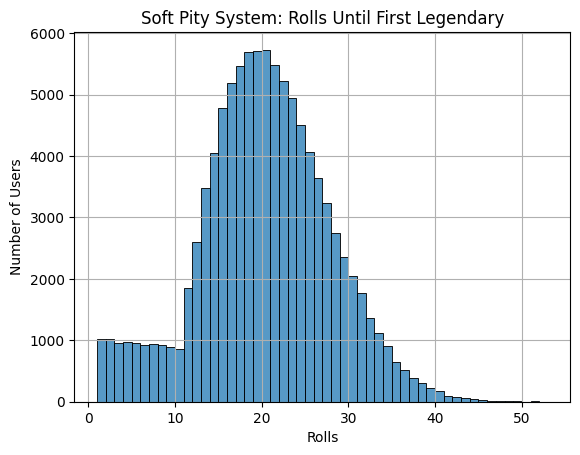

Average rolls to get first Legendary: 19.83
Average rolls is quite close to 20, what a coincidence!


In [ ]:
sns.histplot(results_soft_pity,
             bins=range(1,max(results_soft_pity) + 1), edgecolor='black')
plt.title("Soft Pity System: Rolls Until First Legendary")
plt.xlabel("Rolls")
plt.ylabel("Number of Users")
plt.grid()
plt.show()

avg = sum(results_soft_pity) / len(results_soft_pity)
print(f"Average rolls to get first Legendary: {avg:.2f}")
print("Average rolls is quite close to 20, what a coincidence!")

Let's stick with our original hard pity system and simulate different users. Now, let's modify our code to include another parameter that models a user's behavior.

In [ ]:
def loot_with_pity(
    rolls_before_pity=19,
    pity_weights=[0.45, 0.55],
    behavior_fn=None, # behavior function to simulate different users!
    max_rolls=300  # safety cap for a future user type
):
    counter = 0
    pity_triggers = 0
    loot = []
    rolls = 0

    while rolls < max_rolls:
        if counter == rolls_before_pity:
            rarity = random.choices(
                ["Epic", "Legendary"],
                weights=pity_weights,
                k=1
                )[0]
            loot.append(rarity)
            pity_triggers += 1
            counter = 0
        else:
            rarity = loot_box(rarity_table)
            loot.append(rarity)
            if rarity == "Legendary":
                counter = 0
            else:
                counter += 1

        rolls += 1

        # Different users will stop rolling at some point if there is some type
        # of monetary commitment, which I will add soon.
        if behavior_fn is not None and not behavior_fn(loot, rolls):
            break

    return Counter(loot), pity_triggers, rolls

In [ ]:
# The collector will only stop once he gets a legendary
def collector_behavior(inventory, rolls):
    return 'Legendary' not in inventory # Returns True or False

# The budget user will stop at some point even without a legendary
def budget_user_behavior(inventory, rolls, budget_limit=40):
    return "Legendary" not in inventory and rolls < budget_limit

# The target hunter only needs an epic or legendary to complete his inventory
def target_hunter_behavior(inventory, rolls):
    return not any(i in inventory for i in ["Epic", "Legendary"])

In [ ]:
n_simulations = 100000

collector_results = []
budget_results = []
target_hunter_results = []

for _ in range(n_simulations):
    # Collector
    _, _, rolls_c = loot_with_pity(behavior_fn=collector_behavior)
    collector_results.append(rolls_c) # I'm only interested in the # of rolls

    # Budget user
    _, _, rolls_b = loot_with_pity(
        behavior_fn=lambda inv, r: budget_user_behavior(inv, r, budget_limit=40)
    ) # As budget_user_behavior has 3 arguments
    budget_results.append(rolls_b)

    # Target Hunter
    _, _, rolls_t = loot_with_pity(behavior_fn=target_hunter_behavior)
    target_hunter_results.append(rolls_t)

print('''Let's assume a loot box costs $0.99, so we can estimate how much each
user earns for our fictional game studio''')

Let's assume a loot box costs $0.99, so we can estimate how much each
user earns for our fictional game studio


In [ ]:
def summary(name, data):
    print(f"{name}:")
    print(f"  Avg Rolls: {np.mean(data):.2f}")
    print(f"  Avg Revenue: ${(np.mean(data)*0.99):.2f}")
    print(f"  Min Rolls: {np.min(data)}")
    print(f"  Max Rolls: {np.max(data)}")
    print(f"  90th Percentile: {np.percentile(data, 90)}")
    print("")

summary("Collector", collector_results)
summary("Budget User", budget_results)
summary("Target Hunter", target_hunter_results)

Collector:
  Avg Rolls: 20.39
  Avg Revenue: $20.19
  Min Rolls: 1
  Max Rolls: 171
  90th Percentile: 40.0

Budget User:
  Avg Rolls: 19.09
  Avg Revenue: $18.90
  Min Rolls: 1
  Max Rolls: 40
  90th Percentile: 40.0

Target Hunter:
  Avg Rolls: 8.77
  Avg Revenue: $8.68
  Min Rolls: 1
  Max Rolls: 20
  90th Percentile: 20.0



Many players fall into one of these player archetypes, so let us simulate a player population!

In [ ]:
player_types = {
    'collector': 0.3,
    'budget_user': 0.4,
    'target_hunter': 0.3
}

def get_behavior(player_type):
    if player_type == 'collector':
        return collector_behavior
    elif player_type == 'budget_user':
        return lambda inv, r: budget_user_behavior(inv, r, 40)
    elif player_type == 'target_hunter':
        return target_hunter_behavior

In [ ]:
def simulate_population(n_players=50000, lootbox_cost = 0.99):
  summary_data = {
      "Player Type": [],
      "Rolls": [],
      "Legendary": [],
      "Spent ($)": []
  }
  drop_counts_by_type = defaultdict(Counter)

  player_type_keys = list(player_types.keys())
  weights = list(player_types.values())

  for _ in range(n_players):
    player_type = random.choices(player_type_keys, weights, k=1)[0]
    behavior_fn = get_behavior(player_type)

    drops, pity_count, rolls = loot_with_pity(behavior_fn=behavior_fn)

    summary_data["Player Type"].append(player_type)
    summary_data["Rolls"].append(rolls)
    summary_data["Legendary"].append(int("Legendary" in drops))
    summary_data["Spent ($)"].append(rolls * lootbox_cost)
    drop_counts_by_type[player_type] += drops

  return summary_data, drop_counts_by_type

summary_data, drop_count = simulate_population()

summary_data = pd.DataFrame(summary_data)

In [ ]:
print('% of Players who got a Legendary:')
summary_data.groupby("Player Type")["Legendary"].mean().multiply(100).round(2)

% of Players who got a Legendary:


,Legendary
Player Type,
budget_user,93.16
collector,100.00
target_hunter,33.00


In [ ]:
print('Summary Statistics about our Player Base:')
(summary_data.groupby("Player Type")[[
    "Rolls", "Spent ($)", "Legendary"
    ]]
 ).agg(["mean", "std", "sum"]).style.format({
     ("Rolls", "mean"): "{:.2f}",
     ("Rolls", "std"): "{:.2f}",
     ("Rolls", "sum"): "{:,.0f}",
     ("Spent ($)", "mean"): "${:.2f}",
     ("Spent ($)", "std"): "${:.2f}",
     ("Spent ($)", "sum"): "${:,.0f}",
     ("Legendary", "mean"): "{:.3f}",
     ("Legendary", "std"): "{:.3f}",
     ("Legendary", "sum"): "{:,.0f}",
 })

Summary Statistics about our Player Base:


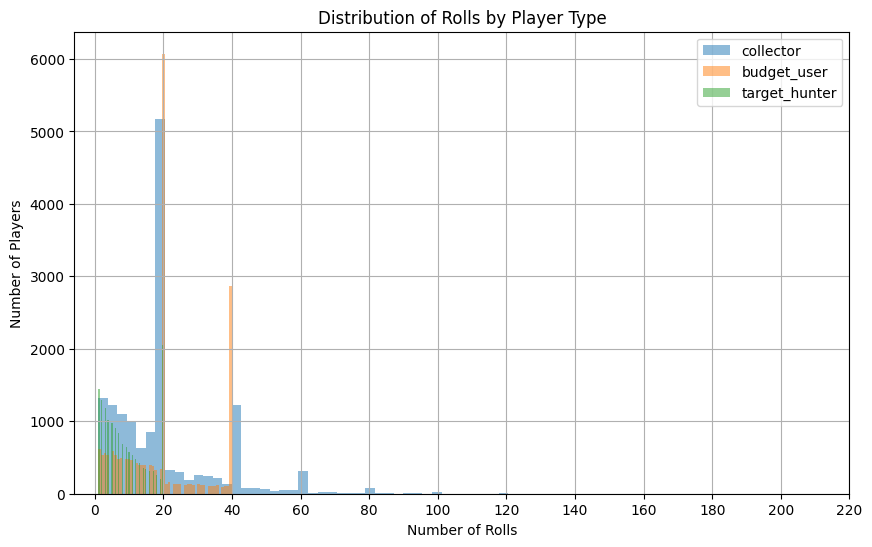

It's hard to read the plot due to the outliers, let's snip them for a better result


In [ ]:
plt.figure(figsize=(10, 6))
for player_type in player_types:
    subset = summary_data[summary_data["Player Type"] == player_type]
    plt.hist(subset["Rolls"], bins=50, alpha=0.5, label=player_type)

plt.title("Distribution of Rolls by Player Type")
plt.xlabel("Number of Rolls")
plt.ylabel("Number of Players")
plt.xticks(np.arange(0,221,20))
plt.legend()
plt.grid()
plt.show()

print("It's hard to read the plot due to the outliers, let's snip them for a better result")

In [ ]:
outlier_threshold = summary_data['Rolls'].quantile(0.99)
filtered_summary = summary_data[summary_data['Rolls'] <= outlier_threshold]

print(f'Rows removed: {summary_data.shape[0] - filtered_summary.shape[0]}')

Rows removed: 255


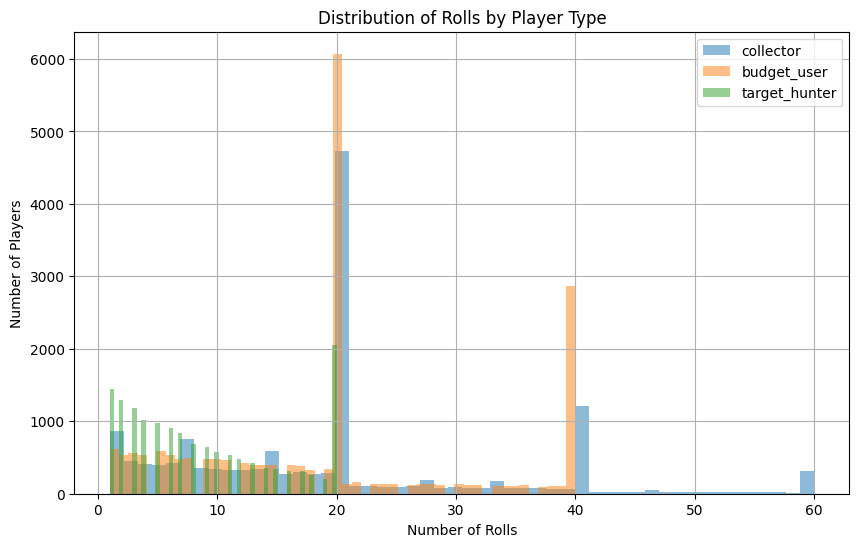

In [ ]:
plt.figure(figsize=(10, 6))
for player_type in player_types:
    subset = filtered_summary[filtered_summary["Player Type"] == player_type]
    plt.hist(subset["Rolls"], bins=50, alpha=0.5, label=player_type)

plt.title("Distribution of Rolls by Player Type")
plt.xlabel("Number of Rolls")
plt.ylabel("Number of Players")
plt.xticks(np.arange(0,61,10))
plt.legend()
plt.grid()
plt.show()